# DTSA 5511 Introduction to Deep Learning Final Project

Location of this project: https://github.com/NikoKuu/Introduction-to-Deep-Learning-final

## Project Topic ##
This work is the final project for DTSA 5511 Introduction to Deep Learning course. The objective is to demonstrate how to use Deep Learning methods, including data cleaning and eploratory data analysis (EDA). 

A dataset of Amazon webstore item descriptions by Pavlo Mospan was selected.
Kaggle is hosting the data set:

Amazon Advertisements, Pavlo Mospan 2019. 

Available at: https://www.kaggle.com/datasets/sachsene/amazons-advertisements/data. 

The plan is to clean up the data, perform basic Exploratory Data Analysis (EDA), vectorize the text descriptions of each item and use Natural Language Processing methods to **categorize the data**. Since the descriptions are sequential data, Recurrent Neural Network (RNN) could be a good fit for this data. Multiple RNN family networks are evaluated, such as Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU). Since the structure of the product descriptions is very simple (barely complete sentences), a traditional machine learing models such as Random Forest should also work well. Thus the NLP/RNN approach will be benchmarked against more traditional approaches.  

## Data ##
The data set consists of 525 csv-files (total of 280MB) in different levels of categories, totaling more than three million items with description. There are about 20 main categories and up to three levels of additional nested categories. The main focus of this work is to cluster the items based on the description text mainly focusing on the main category. 

Some of the text descriptions are very short and frankly impossible to categorize, such as a one-word text of the product part number. The text data also has a lot of numerical values for product dimensions or package quantity that may cause trouble for algorithms. 

Each csv-file has only a column named 'ad' and the first row is the header. Rest of the rows are item description text each item in the category. Category name is extracted from the filename. These files have csv file extensions but they should not treated as such since some of the text have commas in them. 

#### Load the most of the required modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import string

import keras
import tensorflow as tf
from keras import layers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score
%matplotlib inline

## Data Cleaning ##

The default categorization is cleaned by making the following changes and corrections:
* Move items in "home kitchen" category to main category "home" and subcategory "kitchen".
    * There already were some items in the home/kitchen -category.
* Move items in main category industrial/scientific category to common main category "industrial scientific".
    * There already were items in the "industrial scientific" -category.
* "Computers" moved under "electronics" main category
* "Smart home" moved under "electronics" main category
* Fix typo in 'sports'
    * No effect on the categories

Also, puncuation are either removed or made consistent. Word counts are also added for each item to aid in the EDA. 

The code below also does additional cleaning however some of it is not necessary since the vectorizer can do it and some are not used in this work. 


In [2]:
class amz_data:
    def __init__(self):
        self.id = 0
        self.df = pd.DataFrame()
        self.df_cat = pd.DataFrame(columns=['full', 'main', 'sub', 'subsub', 'bottom'])
        self.placeholder = ''#'<NUM>'

    def read_data(self, basedir):
         # https://docs.python.org/3.9/library/os.html?highlight=os%20walk
        for root, dirs, files in os.walk(basedir):
            #print(files)
            for file in files:
                path = os.path.join(root, file)
                self.add_to_dataframe(path)

    def add_to_dataframe(self, path):
        # print(path)
        # Too long path name. Needed to add the prefix for long path names.
        with open(u'\\\\?\\' + os.path.abspath(path), 'r', encoding="utf8") as f:
            # lines = f.readlines()
            lines = f.read().splitlines() # without the \n in the end 
        df = pd.DataFrame(lines[1:], columns=['description'])
        df['id'] = self.id # Assign a unique id
        df['word_count'] = df.apply(self.count_words, axis=1)
        df['description'] = df.apply(self.preprocess_text, axis=1)
        categories = list(self.get_category(os.path.basename(path)))
        df['full'] = categories[0]
        df['main'] = categories[1]
        df['sub'] = categories[2]
        df['subsub'] = categories[3]
        df['bottom'] = categories[4]
        self.df = pd.concat([self.df, df], ignore_index=True)
        # self.df_cat = pd.concat([self.df_cat, [self.id, self.get_category(os.path.basename(path))]], ignore_index=True)
        self.df_cat.loc[len(self.df_cat)] = list(categories)
        self.id = self.id + 1
    
    def get_category(self, file_name):
        if 'home-kitchen' in file_name: # Home kitchen -exception
            file_name = file_name.replace('home-kitchen', 'home_kitchen')
        if 'industrial_scientific' in file_name: # Industrial scientific -exception
            file_name = file_name.replace('industrial_scientific-tests-measurements', 'industrial_scientific_tests-measurements')
            file_name = file_name.replace('industrial_scientific', 'industrial-scientific')
        if '_computers' in file_name: # Computers -exception
            file_name = file_name.replace('_computers', '_electronics_computers')
        if '_smart-home' in file_name: # Smart home -exception
            file_name = file_name.replace('_smart-home', '_electronics_smart-home')
        if 'fan-shop' in file_name: # Fan shop -correction
            file_name = file_name.replace('fan-shop', 'sports-outdoors_fan-shop')
        if 'aports' in file_name: # aports -correction
            file_name = file_name.replace('aports', 'sports')
        category = file_name.split('.')[0]
        cat_list = category.split('_')        
        main = cat_list[1]
        if len(cat_list) >= 4:
            sub = cat_list[2]
        else:
            sub = None
        if len(cat_list) >= 5:
            subsub = cat_list[3]
        else: 
            subsub = None
        bottom = cat_list[-1]
        return category.replace('amazon_',''), main, sub, subsub, bottom
    
    def count_words(self, row):
        words = len(row['description'].split(' '))
        return words
    
    def replace_numbers(self, row):
        text = re.sub(r'\d+', self.placeholder, row['description'])
        return text
    
    def replace_punct_digits(self, text):
        translator = str.maketrans('', '', string.punctuation + string.digits)
        return text.translate(translator)
    
    def replace_multispace(self, text):
        cleaned_text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
        return cleaned_text
    
    def replace_units(self, text):
        text = text.replace('mm','')
        text = text.replace('inches','')
        text = text.replace('inch','')
        text = text.replace('pack','')
        text = text.replace('pcs','')
        text = text.replace('pieces','')
        return text
        
    def preprocess_text(self, row):
        # Remove not helpful words
        text = row['description']
        text = text.lower()
        text = text.replace('|',' ')
        text = text.replace('/',' ')
        text = text.replace(' - ',', ')
        text = text.replace('-',' ')
        text = text.replace('"','')
        text = text.strip()
        pattern = r'\b[a-zA-Z]\b' # Replace single-character words 
        text = re.sub(pattern, '', text)
        # text = self.replace_punct_digits(text)
        text = self.replace_multispace(text)
        return text


#### Loading the data

Load the data from Kaggle, execute the cleaning functions and change category labels' datatype to category (uses less memory).

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sachsene/amazons-advertisements")

amz = amz_data()
amz.read_data(os.path.join(path, 'scrapped_data', 'scrapped_data'))
# print(path)

amz.df['full'] = amz.df['full'].astype('category')
amz.df['main'] = amz.df['main'].astype('category')
amz.df['sub'] = amz.df['sub'].astype('category')
amz.df['subsub'] = amz.df['subsub'].astype('category')
amz.df['bottom'] = amz.df['bottom'].astype('category')

### Dataset info ###

General info and four first and last entries are printed out below to show the general format of the data. 

The dataframe has over three million rows. However, it was found that there are over 150,000 duplicated entries (identical rows). These duplicates had the same category. There are 765,000 duplicate descriptions with different category. Since the models are trying to categorize each item into one category (one-hot coding), these multicategory entries are also removed. Total of ~800,000 items were removed as duplicates. 

No missing values were found besides the expected items that do not have as many sub-categories. 

In [4]:
print(amz.df.info(),'\n')
print(amz.df.head(4),'\n')
print(amz.df.tail(4),'\n')
print('\nNumber of nan values:\n', np.sum(amz.df.isna(), axis=0))
print('\nNumber of duplicated entries:', np.sum(amz.df.duplicated()))
print('Number of duplicated items:', np.sum(amz.df.duplicated(subset='description')))
print('Drop duplicates...')
amz.df.drop_duplicates(inplace=True, subset='description')
print('Number of duplicated items:', np.sum(amz.df.duplicated(subset='description')))
print('Number of items after dropping duplicates:', len(amz.df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318260 entries, 0 to 3318259
Data columns (total 8 columns):
 #   Column       Dtype   
---  ------       -----   
 0   description  object  
 1   id           int64   
 2   word_count   int64   
 3   full         category
 4   main         category
 5   sub          category
 6   subsub       category
 7   bottom       category
dtypes: category(5), int64(2), object(1)
memory usage: 98.1+ MB
None 

                                         description  id  word_count  \
0  hisense 50 inch 4k ultra hd smart led tv 50h60...   0          10   
1  vizio 55 inches 4k ultra hd smart led tv p55 e...   0          11   
2  sony xbr49x900e series 49 class hdr uhd smart ...   0           8   
3  tivo bolt vox 1tb, dvr & streaming media playe...   0          17   

                     full         main  sub subsub      bottom  
0  electronics_smart-home  electronics  NaN    NaN  smart-home  
1  electronics_smart-home  electronics  NaN    NaN  smar

Total of 439 most detailed level categories were found and those are grouped into 17 main categories.

In [5]:
print(amz.df_cat.info(), '\n')
print('Any duplicated categories:', np.any(amz.df_cat.duplicated()), '\n')
print('Number of full categories:', len(pd.unique(amz.df_cat['full'])))
print('Number of main categories:', len(pd.unique(amz.df_cat['main'])))
print('Number of sub-categories:', len(pd.unique(amz.df_cat['sub'])))
print('Number of lower sub-categories:', len(pd.unique(amz.df_cat['subsub'])))
print('Number of most detailed categories:', len(pd.unique(amz.df_cat['bottom'])))

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 524
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    525 non-null    object
 1   main    525 non-null    object
 2   sub     390 non-null    object
 3   subsub  48 non-null     object
 4   bottom  525 non-null    object
dtypes: object(5)
memory usage: 24.6+ KB
None 

Any duplicated categories: False 

Number of full categories: 525
Number of main categories: 17
Number of sub-categories: 29
Number of lower sub-categories: 12
Number of most detailed categories: 439


## Exploratory Data Analysis ##

### Word counts

Below a histogram of approximate word counts is plotted. The distribution looks reasonable.

Also the shortest and the longest desriptions are found showing that the shortest has only one word and the longest has 186 words in them. The mean of the number of words is 13 with standard deviation of 7. We can see that using only 25 words covers already majority of the items and 98% of the items have 31 or less words. 

Lastly, the box plot shows how many words each main category has. There does not seem to be significant difference in the description length between the main categories.  

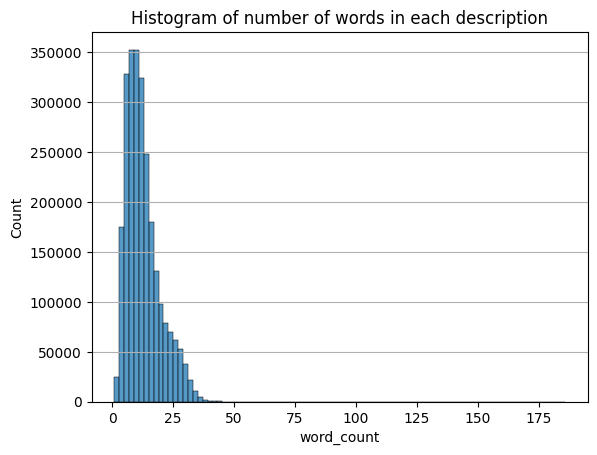

Maximum number of words: 186
Minimum number of words: 1
Mean number of words: 13
Standard deviation of number of words: 7 

Entry with the minimum amount of words:
 description                b06xpp7wjz
id                                  0
word_count                          1
full           electronics_smart-home
main                      electronics
sub                               NaN
subsub                            NaN
bottom                     smart-home
Name: 799, dtype: object
98th percentile: 31.0


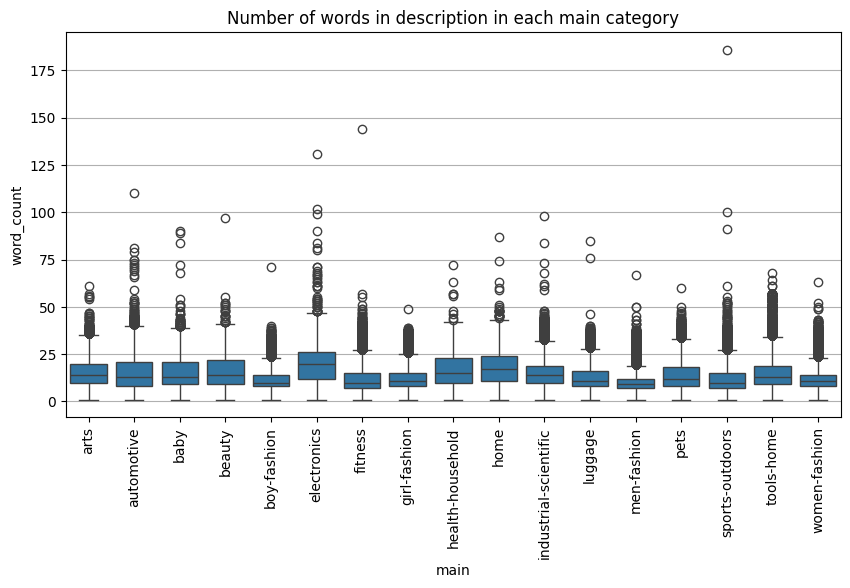

In [6]:
sns.histplot(amz.df, x='word_count', binwidth=2)
plt.grid(axis='y')
plt.title('Histogram of number of words in each description')
plt.show()
print('Maximum number of words:', max(amz.df['word_count']))
print('Minimum number of words:', min(amz.df['word_count']))
print('Mean number of words:', round(np.mean(amz.df['word_count'])))
print('Standard deviation of number of words:', round(np.std(amz.df['word_count'])), '\n')
print('Entry with the minimum amount of words:\n', amz.df.iloc[np.argmin(amz.df['word_count'])])
print('98th percentile:', np.percentile(amz.df['word_count'],98))

fig = plt.figure(figsize=(10, 5))
sns.boxplot(amz.df, x='main', y='word_count')
plt.xticks(rotation=90, fontsize = 10) 
plt.title('Number of words in description in each main category')
plt.grid(axis='y')
plt.show()


#### Number of items in each category

Below, first the number of items in each main category is plotted. Then then number of items in each detailed category is plotted. 

Women's fashion is the largest main category with over 500,000 items and health household has the least amount of items. 

In detailed categories, fan shop is extremely large category (73,000 items) compared to the others and some categories have only 6 items. Learning from very small categories may not work well.

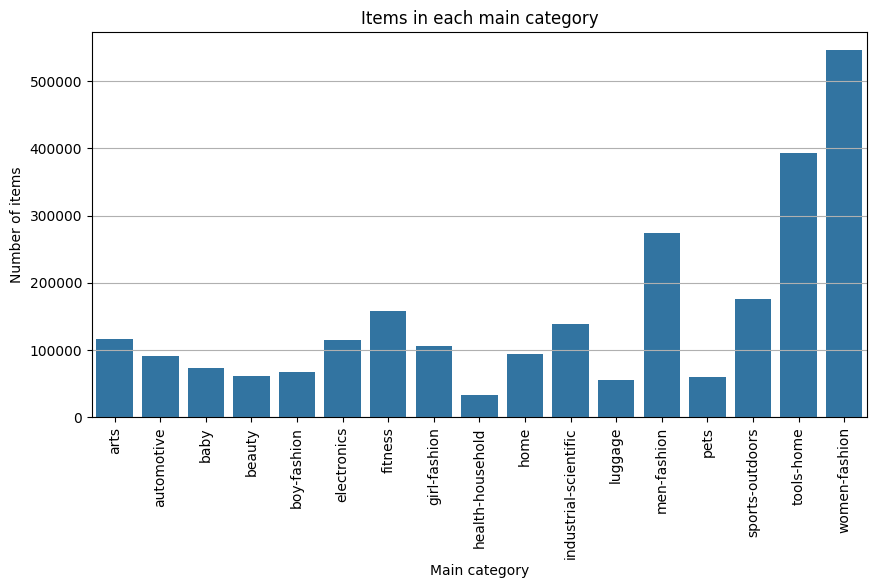

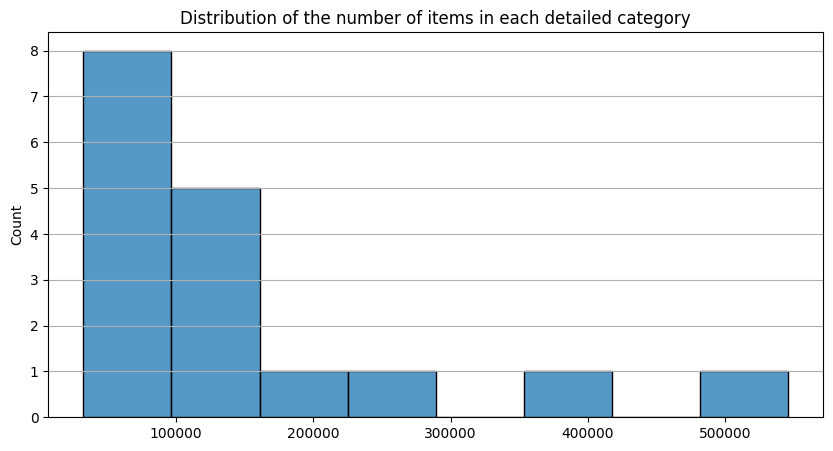

Maximum number of items: 545838
Minimum number of items: 32418
Mean number of items: 150206
Standard deviation of number of items: 131652 

Item count of the five largest categories:
 main
women-fashion    545838
tools-home       393049
men-fashion      273552
dtype: int64 

Item count of the five smallest categories:
 main
health-household    32418
luggage             55010
pets                59668
dtype: int64


In [7]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(amz.df, x='main', stat='count')
plt.title('Items in each main category')
plt.xlabel('Main category')
plt.ylabel('Number of items')
plt.xticks(rotation=90, fontsize = 10)
plt.grid(axis='y')
plt.show()

fig = plt.figure(figsize=(10, 5))
sizes = amz.df.groupby('main', observed=True).size()
sns.histplot(sizes)
plt.title('Distribution of the number of items in each detailed category')
plt.grid(axis='y')
plt.show()

print('Maximum number of items:', max(sizes))
print('Minimum number of items:', min(sizes))
print('Mean number of items:', round(np.mean(sizes)))
print('Standard deviation of number of items:', round(np.std(sizes)), '\n')

print('Item count of the five largest categories:\n', 
      sizes.sort_values(ascending=False)[0:3], '\n')
print('Item count of the five smallest categories:\n', 
      sizes.sort_values(ascending=True)[0:3])


### Dataset preparation

For testing and exploration purposes, the code below allows to select a random subset of certain number of categories, either using main or most detailed category. The models in this final version will be trained with full dataset and main-category. 

In [8]:
import random
random.seed(215)
number_of_categories = 17

main_category = True
truncate = False

mask = []
counts_train = []
if main_category:
    cat_name = 'main'
else:
    cat_name = 'full'
chosen_categories = random.sample(list(pd.unique(amz.df_cat[cat_name])), number_of_categories)
for index, cat in enumerate(chosen_categories): # Find the rows with target categories
    m = amz.df[cat_name] == cat
    counts_train.append(sum(m)) # Record the number of items 
    mask.append(m)
amount = min(counts_train)
idx_all = []
for index, cat in enumerate(chosen_categories):
    m = amz.df[cat_name] == cat
    if truncate:
        idx_all.append(np.where(m)[0][0:amount])
    else:
        idx_all.append(np.where(m)[0])

idx_all = [item for sublist in idx_all for item in sublist]
df = amz.df.iloc[idx_all]

chosen_categories = pd.unique(df[cat_name])
# categories_train = [s.replace('-',' ').replace('_',' - ') for s in categories_train]
print('Chosen categories and number of items:')
print('\n'.join([cat+': '+str(cnt) for cat, cnt in zip(chosen_categories, counts_train)]))
# temp_df = pd.DataFrame(np.array([chosen_categories, counts_train]).transpose(), columns=['category', 'items'])


Chosen categories and number of items:
arts: 116128
luggage: 55010
women-fashion: 545838
sports-outdoors: 175390
beauty: 60892
baby: 72474
fitness: 157428
electronics: 114517
home: 93186
girl-fashion: 106459
automotive: 90845
boy-fashion: 67428
industrial-scientific: 139219
pets: 59668
health-household: 32418
men-fashion: 273552
tools-home: 393049


The data is split into following sub-datasets:

* 70% training
* 20% validation
* 20% test

The splitting function also tries to stratify the data so the uneven categories do not skew the model training. 

In [9]:
test_split = 0.4

# Initial train and test split.
train_df, test_df = train_test_split(
    df,
    test_size=test_split,
    stratify=df[cat_name].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: \t{len(train_df)}, \t{round(100*len(train_df)/len(df))}%")
print(f"Number of rows in validation set: \t{len(val_df)}, \t{round(100*len(val_df)/len(df))}%")
print(f"Number of rows in test set: \t\t{len(test_df)}, \t{round(100*len(test_df)/len(df))}%")
print('')
print('Number of items in each category in the training set:')
for index, cat in enumerate(chosen_categories):
    m = train_df[cat_name] == cat
    print(cat, ':\t', sum(m), 'items')

Number of rows in training set: 	1532100, 	60%
Number of rows in validation set: 	510700, 	20%
Number of rows in test set: 		510701, 	20%

Number of items in each category in the training set:
arts :	 69677 items
luggage :	 33006 items
women-fashion :	 327503 items
sports-outdoors :	 105234 items
beauty :	 36535 items
baby :	 43484 items
fitness :	 94457 items
electronics :	 68710 items
home :	 55912 items
girl-fashion :	 63875 items
automotive :	 54507 items
boy-fashion :	 40457 items
industrial-scientific :	 83531 items
pets :	 35801 items
health-household :	 19451 items
men-fashion :	 164131 items
tools-home :	 235829 items


We use standard batch size of 32, maximum of 20,000 word vocabulary and the descriptions truncated at 31 words. 

In [10]:
# Model constants.
batch_size = 32
max_features = 20000
embedding_dim = 128
sequence_length = 31

Since this is multi-category classification we need to have the categories one-hot binary coded. 

In [11]:
# https://keras.io/examples/nlp/multi_label_classification/
terms = tf.ragged.constant(train_df[cat_name].values)
lookup = layers.StringLookup(output_mode="one_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe[cat_name].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["description"].values, label_binarized)
    )
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)  
    return dataset.batch(batch_size)
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [12]:
train_ds = make_dataset(train_df, is_train=True)
val_ds = make_dataset(val_df, is_train=False)
test_ds = make_dataset(test_df, is_train=False)

A couple of samples pulled from the training dataset with one-hot coding.

In [13]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print('')
        print('*' * 40, i+1, '*' * 40)
        print(label_batch.numpy()[i], '\t\t', invert_multi_hot(label_batch.numpy()[i]))
        print(text_batch.numpy()[i])



**************************************** 1 ****************************************
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['tools-home']
b'leviton 84112 40 4 gang toggle device switch wallplate, oversized, device mount, stainless steel'

**************************************** 2 ****************************************
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['tools-home']
b'3drose lsp_183699_1 print of famous kraken octopus in blue light switch cover'

**************************************** 3 ****************************************
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] 		 ['arts']
b'12 jumbo christmas reusable gift bag grocery shopping totes for the holidays'

**************************************** 4 ****************************************
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['men-fashion']
b"invicta men' 13058 vintage gold tone stainless steel watch with distressed leather band"

**************************************** 5 ****************************************
[0 0

The words in the training set need to be vectorized into numbers. The below code creates a vectorizer that can be used to transform text data to number matrices. The words in the training set are used for creating the vocalbulary (vectorize layer). 

In [14]:
# https://keras.io/examples/nlp/text_classification_from_scratch/

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=sequence_length,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    name=None
)
# Now that the vectorize_layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

In [15]:
# https://keras.io/examples/nlp/text_classification_from_scratch/
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Now that the text has been vectorized we pull an example of a sample from the dataset.

In [16]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print('')
        print('*' * 40, i+1, '*' * 40)
        print(label_batch.numpy()[i], '\n', text_batch.numpy()[i])
    print(text_batch[0].shape)
print('\nVectorized text datatype:', type(text_batch.numpy()[i][0]))


**************************************** 1 ****************************************
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [  79  455  135  327  381  225 1985  225  229   81  896    1 5112 1075
 2375   81  896 1075 1633    0    0    0    0    0    0    0    0    0
    0    0    0]

**************************************** 2 ****************************************
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [1297    1  358   12 1488  956 1275  183 3701 1092 1275  124   36   21
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]

**************************************** 3 ****************************************
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] 
 [2581 3185  690 1181  385    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
(31,)

Vectorized text datatype: <class 'numpy.int64'>


## Models

The input layer is the same in all the models so it can be reused.

The output layer is fully connected neural net with softmax activation. Softmax gives probability for each category and thus makes interpretation prediction easier.

In [17]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int64")

### 1. Baseline - 1D CNN

This is a fairly simple model that uses two convolutional layers (1D convolution layer, good for temporal convolution), and one fully connected layer. Activations are all ReLU, except for the output layer. 

With this model, we can experiment with the number of filters and dropout rates.


In [ ]:
# Source: https://keras.io/examples/nlp/text_classification_from_scratch/

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(number_of_categories+1, activation="softmax", name="predictions")(x)

model1 = keras.Model(inputs, predictions)

model1.name = '1D-CNN'
model1.summary()


Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,808,466 (10.71 MB)

 Trainable params: 2,808,466 (10.71 MB)

 Non-trainable params: 0 (0.00 B)

### 2. LSTM - Long Short Term Memory network

LSTM network should be able take better account previous words (vanishing gradient problem) by being able to retain information for longer period of timesteps. Otherwise, the architecture is similar to the previous model. 

In [82]:
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Dropout(0.5)(x)
# Add 2 LSTMs
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.5)(x)
# Add a classifier
outputs = layers.Dense(number_of_categories+1, activation="softmax")(x)
model2 = keras.Model(inputs, outputs)
model2.name = 'LSTM'
model2.summary()


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_15 (Embedding)        │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,490 (10.78 MB)

 Trainable params: 2,825,490 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

### 3. LSTM - Long Short Term Memory network with Dropout

This LSTM adds dropout function into LSTM layers.

In [85]:
## Source: https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-impleme
# We need sequential model to process sequence of text data
model3 = keras.models.Sequential()
model3.add(inputs)
# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize t
embedding= layers.Embedding(max_features, 128)#, trainable=False)
# Adding Embedding Layer
model3.add(embedding)
# Drops 40% of entire row
model3.add(layers.Dropout(0.5))
# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent
model3.add(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model3.add(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5))
# Decide what we are going to output Dense(units, activation function)
model3.add(layers.Dense(number_of_categories+1, activation='softmax'))
model3.name = 'LSTM-dropout'
model3.summary()


Model: "LSTM-dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,490 (10.78 MB)

 Trainable params: 2,825,490 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

 ### 4. GRU - Gated Recurrent Unit

The GRU architecture should be slightly lighter than LSTM, having fewer parameters, but otherwise similar. 

In [83]:
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Dropout(0.5)(x)
# Add 2 GRUs
x = layers.GRU(128, return_sequences=True)(x)
x = layers.GRU(128)(x)

# Add a classifier
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(number_of_categories+1, activation='softmax')(x)

model4 = keras.Model(inputs, outputs)

model4.name = 'GRU'
model4.summary()


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_16 (Embedding)        │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,760,466 (10.53 MB)

 Trainable params: 2,760,466 (10.53 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Just regular densely-connected Neural Net layer
This model has two fully connected Neural Nets, both with 128 filters by default. 

In [72]:
# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# We add a vanilla hidden layer:
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling1D()(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(number_of_categories+1, activation="softmax", name="predictions")(x)

model5 = keras.Model(inputs, predictions)

model5.name = 'NN-only256'
model5.summary()


Model: "NN-only256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, None, 256)      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, None, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,663,442 (10.16 MB)

 Trainable params: 2,663,442 (10.16 MB)

 Non-trainable params: 0 (0.00 B)

## Train the models

The code below compiles the model using categorical crossentropy for the loss function and Adam optimizer. The it runs the training and finally saves the model and training history on the disk.

In [20]:
def train_save_model(model, epochs=5):
    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Fit the model using the train and validation datasets.
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    # Save the training history
    result_df = pd.DataFrame(np.array([history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']]).transpose(), 
                             columns=['acc','val_acc','loss','val_loss'])
    result_df.to_csv(model.name + '.csv')
    # Save the model, including the weights
    model.save(model.name + '.keras')


In [ ]:
# os.environ['TF_DISABLE_MKL'] = '1'

In [ ]:
print('Train model', model1.name)
train_save_model(model1, 5)
print('Evaluate model', model1.name)
model1.evaluate(test_ds)

baseline
Epoch 1/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 401s 8ms/step - accuracy: 0.7231 - loss: 0.9269 - val_accuracy: 0.8241 - val_loss: 0.5690
Epoch 2/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 370s 8ms/step - accuracy: 0.8121 - loss: 0.6316 - val_accuracy: 0.8292 - val_loss: 0.5464
Epoch 3/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 420s 9ms/step - accuracy: 0.8200 - loss: 0.6034 - val_accuracy: 0.8324 - val_loss: 0.5436
Epoch 4/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 385s 8ms/step - accuracy: 0.8241 - loss: 0.5906 - val_accuracy: 0.8337 - val_loss: 0.5401
Epoch 5/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 436s 9ms/step - accuracy: 0.8262 - loss: 0.5845 - val_accuracy: 0.8336 - val_loss: 0.5422
15960/15960 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.8341 - loss: 0.5389


[0.5419902205467224, 0.8332527279853821]

In [ ]:
print('Train model', model2.name)
train_save_model(model2, 5)
print('Evaluate model', model2.name)
model2.evaluate(test_ds)

Epoch 1/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1084s 23ms/step - accuracy: 0.7273 - loss: 0.9074 - val_accuracy: 0.8367 - val_loss: 0.5059
Epoch 2/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1103s 23ms/step - accuracy: 0.8292 - loss: 0.5430 - val_accuracy: 0.8435 - val_loss: 0.4816
Epoch 3/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1130s 24ms/step - accuracy: 0.8372 - loss: 0.5132 - val_accuracy: 0.8466 - val_loss: 0.4731
Epoch 4/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1134s 24ms/step - accuracy: 0.8411 - loss: 0.5001 - val_accuracy: 0.8475 - val_loss: 0.4690
Epoch 5/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1142s 24ms/step - accuracy: 0.8428 - loss: 0.4928 - val_accuracy: 0.8486 - val_loss: 0.4648
15960/15960 ━━━━━━━━━━━━━━━━━━━━ 168s 11ms/step - accuracy: 0.8477 - loss: 0.4680


[0.46797120571136475, 0.848055899143219]

In [86]:
print('Train model', model3.name)
train_save_model(model3, 5)
print('Evaluate model', model3.name)
model3.evaluate(test_ds)

Train model LSTM-dropout
Epoch 1/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1400s 29ms/step - accuracy: 0.6645 - loss: 1.0906 - val_accuracy: 0.8216 - val_loss: 0.5622
Epoch 2/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1317s 28ms/step - accuracy: 0.8077 - loss: 0.6115 - val_accuracy: 0.8284 - val_loss: 0.5367
Epoch 3/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1299s 27ms/step - accuracy: 0.8134 - loss: 0.5894 - val_accuracy: 0.8300 - val_loss: 0.5281
Epoch 4/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1301s 27ms/step - accuracy: 0.8161 - loss: 0.5800 - val_accuracy: 0.8318 - val_loss: 0.5230
Epoch 5/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1332s 28ms/step - accuracy: 0.8177 - loss: 0.5747 - val_accuracy: 0.8324 - val_loss: 0.5203
Evaluate model LSTM-dropout
15960/15960 ━━━━━━━━━━━━━━━━━━━━ 170s 11ms/step - accuracy: 0.8321 - loss: 0.5189


[0.5210431814193726, 0.8317175507545471]

In [84]:
print('Train model', model4.name)
train_save_model(model4, 5)
print('Evaluate model', model4.name)
model4.evaluate(test_ds)

Train model GRU
Epoch 1/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1468s 31ms/step - accuracy: 0.7317 - loss: 0.8773 - val_accuracy: 0.8361 - val_loss: 0.5100
Epoch 2/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1472s 31ms/step - accuracy: 0.8262 - loss: 0.5526 - val_accuracy: 0.8420 - val_loss: 0.4883
Epoch 3/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1630s 34ms/step - accuracy: 0.8335 - loss: 0.5267 - val_accuracy: 0.8442 - val_loss: 0.4810
Epoch 4/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1361s 28ms/step - accuracy: 0.8364 - loss: 0.5165 - val_accuracy: 0.8458 - val_loss: 0.4766
Epoch 5/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1325s 28ms/step - accuracy: 0.8373 - loss: 0.5137 - val_accuracy: 0.8460 - val_loss: 0.4771
Evaluate model GRU
15960/15960 ━━━━━━━━━━━━━━━━━━━━ 164s 10ms/step - accuracy: 0.8457 - loss: 0.4761


[0.47836458683013916, 0.845134437084198]

In [73]:
print('Train model', model5.name)
train_save_model(model5, 5)
print('Evaluate model', model5.name)
model5.evaluate(test_ds)

Train model NN-only256
Epoch 1/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 460s 10ms/step - accuracy: 0.7276 - loss: 0.9180 - val_accuracy: 0.8163 - val_loss: 0.6111
Epoch 2/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 463s 10ms/step - accuracy: 0.8059 - loss: 0.6466 - val_accuracy: 0.8216 - val_loss: 0.5912
Epoch 3/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 491s 10ms/step - accuracy: 0.8125 - loss: 0.6207 - val_accuracy: 0.8236 - val_loss: 0.5843
Epoch 4/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 523s 11ms/step - accuracy: 0.8154 - loss: 0.6080 - val_accuracy: 0.8242 - val_loss: 0.5775
Epoch 5/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 538s 11ms/step - accuracy: 0.8177 - loss: 0.6001 - val_accuracy: 0.8254 - val_loss: 0.5754
Evaluate model NN-only256
15960/15960 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.8269 - loss: 0.5707


[0.5732502937316895, 0.8263739347457886]

## Testing of the models


In [ ]:
# recall_model = keras.models.load_model(r'..\results\NN-only.keras')
# recall_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
recall_model = keras.models.load_model(r'..\results\NN-only.keras')
print(recall_model.name)
print(recall_model.summary())
# print(recall_model.get_weights())
recall_model.evaluate(test_ds)

## Alternative methods
Trying more 'traditional' machine learning methods here. Probably the large amount of data caused the Random Forest and Support Vector Machine models not to work. Naive Bayesian performs poorly.

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, 
                                    norm='l2', encoding='latin-1', ngram_range=(1, 2), 
                                    stop_words="english", max_features=max_features, strip_accents='ascii')
X_train = my_vectorizer.fit_transform(train_df['description'])

print('Shape of the train data matrix:', X_train.shape)
ftr_names = my_vectorizer.get_feature_names_out()
print('Length of ftr_names:', len(ftr_names))
print('Sample of the feature names:\n', ftr_names[100:200])

X_test = my_vectorizer.transform(test_df['description'])
print('Shape of the test data matrix:', X_test.shape)


Shape of the train data matrix: (1532100, 20000)
Length of ftr_names: 20000
Sample of the feature names:
 ['10 wire' '10 women' '10 yards' '10 years' '100' '100 amp' '100 box'
 '100 cashmere' '100 cotton' '100 count' '100 feet' '100 foot' '100 ft'
 '100 led' '100 length' '100 mm' '100 natural' '100 organic' '100 pack'
 '100 pcs' '100 piece' '100 pieces' '100 pk' '100 polyester' '100 pure'
 '100 sheets' '100 silk' '100 uv' '100 waterproof' '100 watt' '100 wool'
 '1000' '1000 lumen' '1000 lumens' '10000' '1000pcs' '1000w' '1001' '100a'
 '100ft' '100g' '100m' '100ml' '100mm' '100pcs' '100w' '101' '101 year'
 '1010' '102' '103' '104' '105' '1050' '106' '1060' '107' '108' '1080'
 '1080p' '1080p hd' '1080p wifi' '109' '10a' '10cm' '10ft' '10g' '10k'
 '10k gold' '10k round' '10k white' '10k yellow' '10l' '10m' '10ml' '10mm'
 '10mm 12mm' '10oz' '10pack' '10pcs' '10pk' '10s' '10v' '10w' '10x' '11'
 '11 11' '11 12' '11 13' '11 14' '11 16' '11 17' '11 32' '11 black'
 '11 inch' '11 inches' '11 men

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# my_RF = RandomForestClassifier().fit(X_train, train_df['main']) # Create the model
# y_hat_RF = my_RF.predict(X_test)
# accuracy = accuracy_score(test_df['main'], y_hat_RF)
# print(accuracy)


In [ ]:
# from sklearn.svm import SVC

# my_SVC = SVC().fit(X_train, train_df['main']) # Create the model
# y_hat_SVC = my_SVC.predict(X_test)
# accuracy = accuracy_score(test_df['main'], y_hat_SVC)
# print(accuracy)


In [ ]:
from sklearn.naive_bayes import CategoricalNB

print('Train')
my_NB = CategoricalNB().fit(X_train.toarray(), train_df['main']) # Create the model
print('Predict')
y_hat_NB = my_NB.predict(X_test)
accuracy = accuracy_score(test_df['main'], y_hat_NB)
print(accuracy)
print(test_df['main'][0:10].values, y_hat_NB[0:10])

### Model result comparisons

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

files = os.listdir(r'..\\results')
df = pd.DataFrame()
for file in files:
    if file[-4:] == '.csv' and file !='training_history.csv':
        new_df = pd.read_csv(r'..\\results' + r'\\' + file)
        new_df.drop(columns='Unnamed: 0', inplace=True)
        new_df['epoch'] = new_df.index + 1
        parts = file.split('.')[0].split('_')
        new_df['model'] = parts[0]
        if len(parts) > 1:
            new_df['parameter'] = parts[1]
        else:
            new_df['parameter'] = 'default'
        df = pd.concat([df, new_df])
# print(df)
# df.to_csv('training_history.csv')

#### Compare different architectures
The model architectures to compare are:
* 1D-CNN: One-dimensional Convolutional Neural Network
* GRU: Gated Recurrent Unit
* LSTM: Long Short Term Memory
* LSTM-dropout: Long Short Term Memory with dropout
* NN: Simple Neural Network

LSTM achieves the highest accuracy at around 85% accuracy but the weakest, simple Neural Network, is very close at 82.5%. Training a few more epochs would have been beneficial for most of the models. 


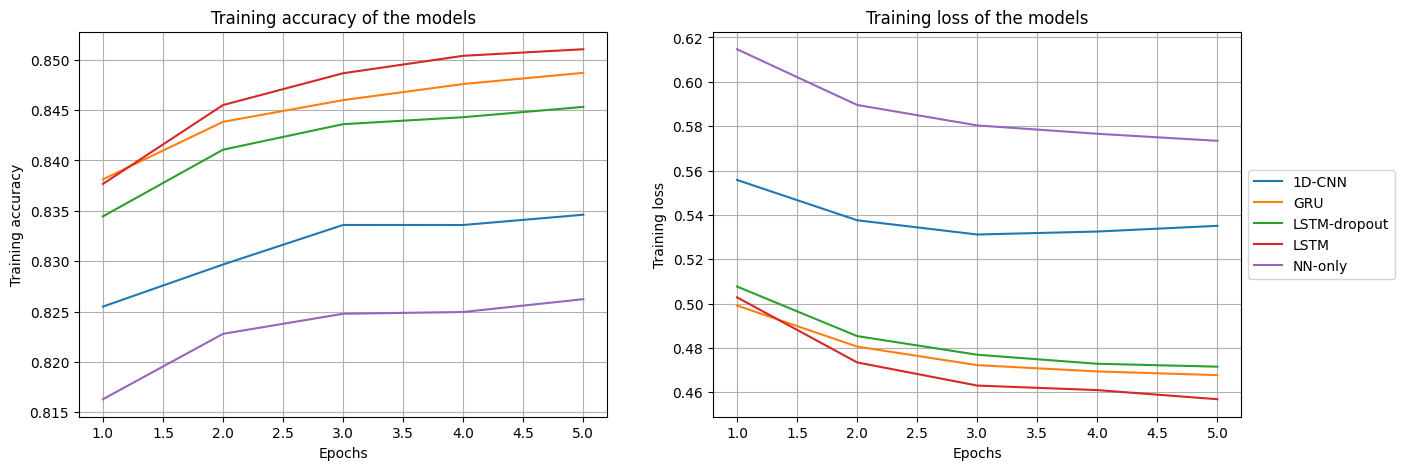

In [ ]:


fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.lineplot(df[df['parameter']=='default'], x='epoch', y='val_acc', hue='model', legend=False, ax=ax[0])
sns.lineplot(df[df['parameter']=='default'], x='epoch', y='val_loss', hue='model', ax=ax[1])
ax[0].set_title('Training accuracy of the models')
ax[0].set_ylabel('Training accuracy')
ax[0].set_xlabel('Epochs')
ax[0].grid(True)
ax[1].set_title('Training loss of the models')
ax[1].set_ylabel('Training loss')
ax[1].set_xlabel('Epochs')
ax[1].grid(True)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Compare different hyperparameters
Some of the hyperparameters are varied here:
* Default: as it is shown in the code earlier.
* 0p25Dropout: Change the dropout rate from 0.5 to 0.25.
* 256conv1D: Change the number of filters in the CNNs from 128 to 256.
* 2strides: Change the stride in the CNNs from 3 to 2.

Having a smaller dropout rate seems to be marginally better. 

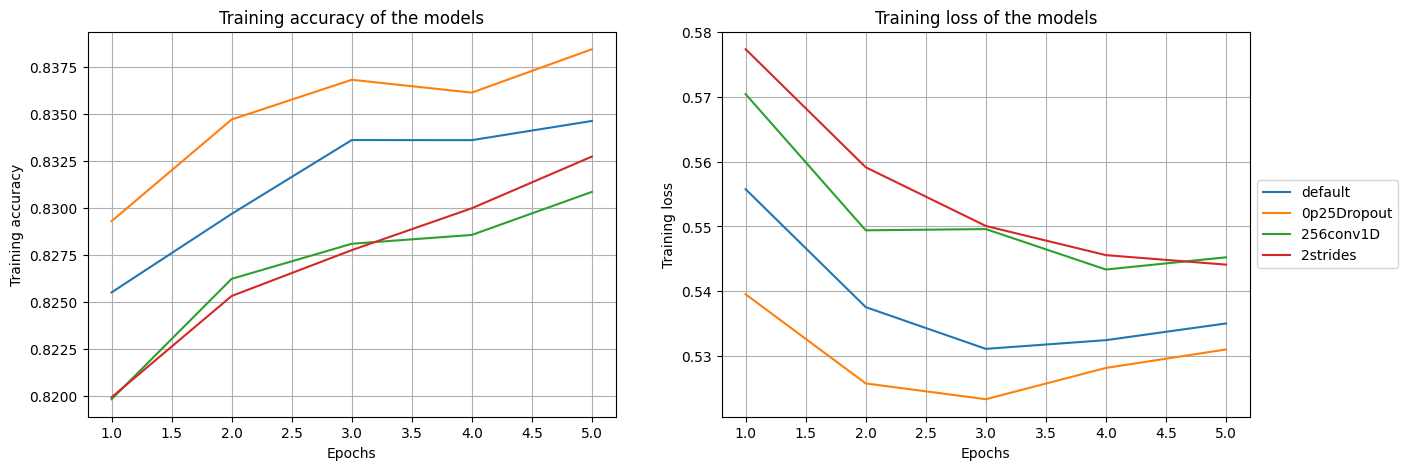

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.lineplot(df[df['model']=='1D-CNN'], x='epoch', y='val_acc', hue='parameter', legend=False, ax=ax[0])
sns.lineplot(df[df['model']=='1D-CNN'], x='epoch', y='val_loss', hue='parameter', ax=ax[1])
ax[0].set_title('Training accuracy of the 1D-CNN models')
ax[0].set_ylabel('Training accuracy')
ax[0].set_xlabel('Epochs')
ax[0].grid(True)
ax[1].set_title('Training loss of the models')
ax[1].set_ylabel('Training loss')
ax[1].set_xlabel('Epochs')
ax[1].grid(True)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Discussion and conclusion ##
All the models ended up slighlty above 80% accuracy with the test set. The RNN models did not significantly improve the score over simpler approaches. I suspect that the more RNN models did not show improvement because of the simple structure of the product descriptions. When just key words are being listed without a clear sentence structure, the main strength of the RNNs, handling of sequential data, goes unutilized: previous and following words have very little relevance. 

### Training time ###
I ended up running all the training on my laptop. The 1D-CNN and neural net only models were much faster to train, roughly 3...4x faster. Using only 60% of the data for training sped up the process a little. 
The 1D-CNN and Neural Net only took about 30min and the LSTM and GRU run for about two hours. 

### Additional improvements
Focusing on further improving the Neural-Net-only model is the best bet since RNN don't provide much benefit with this kind of data. Adding more filters and layers are the most obvious first steps.

Could trouble-shoot the traditional Machine Learning models more so that they could be benchmarked against Deep Learning methods.  

### Challenges
There were some challenges getting the dataset work properly. 

Loading a saved model along with the weights did not seem to work always resulting only 20% accuracy. That is about the same as untrained model so maybe the weights did not load properly or optimizer was reset (Adam depends on previous state). 

Training traditional machine learning models was also challenging. I suspect that just because of the large amount of data. Training seems to be running fine but then the whole computer had restarted during overnight training. 

## Sources

https://keras.io/examples/nlp/text_classification_from_scratch/

https://keras.io/examples/nlp/bidirectional_lstm_imdb/

https://keras.io/examples/nlp/multi_label_classification/

https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-impleme

My final project for DTSA 5510 Unsupervised Algorithms in Machine Learning
